<a href="https://colab.research.google.com/github/vroomgit/FraudDetectionFNN/blob/main/Fraud_Detection_Feedforward_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Oct  3 21:59:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    46W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!cd '/content/drive/MyDrive/Projects/Finance Dataset Kaggle'

In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
import time
from time import sleep
from tqdm import tqdm, trange
from prettytable import PrettyTable

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [54]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Finance Dataset Kaggle/FFDS.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# Percentage of labels = 1
(len(df)-len(df[df['isFraud']==1]))/len(df)

0.9987091795518198

In [56]:
# dropping column 'isFlaggedFraud'
df.drop(columns=['isFlaggedFraud'],inplace=True)

In [22]:
# Number of nulls in dataset
for col in df.columns:
    print(col, df[col].isnull().sum())

step 0
type 0
amount 0
nameOrig 0
oldbalanceOrg 0
newbalanceOrig 0
nameDest 0
oldbalanceDest 0
newbalanceDest 0
isFraud 0


## Choosing columns that will be encoded and calculating embedding sizes. 

Borrowed from https://jovian.ai/aakanksha-ns/shelter-outcome 

In [57]:
# Changing datatypes of 'object' types to 'category'

df["step"] = df["step"].astype("category")
df["type"] = df["type"].astype("category")
df["nameOrig"] = df["nameOrig"].astype("category")
df["nameDest"] = df["nameDest"].astype("category")
embedded_c = []
for col in df.columns:
    if df.dtypes[col] == "object" or df.dtypes[col] == "category":
        embedded_c.append(col)

In [59]:
# Defining labels
Y = df['isFraud']
df.drop(columns=['isFraud'],inplace=True)
print(len(df),len(Y))

6362620 6362620


In [60]:
# calculating number of categories in 'category' type columns.
embedded_cols = {}
for n,col in df.items():
  if str(df.dtypes[col.name]) == "category":
    if len(col.cat.categories) > 2:
      embedded_cols[col.name] = len(col.cat.categories)
embedded_cols

{'step': 743, 'type': 5, 'nameOrig': 6353307, 'nameDest': 2722362}

In [61]:
# computing embedding sizes
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]
embedding_sizes

[(743, 50), (5, 3), (6353307, 50), (2722362, 50)]

In [62]:
embedded_col_names = embedded_cols.keys()

5

Encoding text categories in 'category' columns to integer codes using Sklearn's LabelEncoder

In [63]:
for col in df.columns:
  if (df.dtypes[col]) == "category":
    df[col] = LabelEncoder().fit_transform(df[col])

Portioning 70% data for training and 15% each for validation and testing.

In [64]:
np.random.seed(13)
X_train, X_val_test, y_train, y_val_test = train_test_split(df, Y, test_size=0.30)
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
3992863,297,3,10065.90,2897705,0.0,0.00,1427538,0.00,0.00
5609048,393,3,35667.84,3662289,69610.0,33942.16,1614022,0.00,0.00
6043451,489,0,408532.84,5627573,16636.0,425168.84,534679,809226.78,400693.94
1219187,132,1,455613.55,3461200,257470.0,0.00,423423,94728.63,550342.17
5325276,373,0,267214.37,3376548,21180.0,288394.37,401669,0.00,0.00


In [65]:
np.random.seed(13)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50)

In [66]:
# reset indexes to avoid errors in dataloader class
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [67]:
print(len(X_train),len(y_train),len(X_val),len(y_val),len(X_test),len(y_test))

4453834 4453834 954393 954393 954393 954393


Data after encoding 'category' columns.

In [68]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0
1,0,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0
2,0,4,181.00,1002156,181.0,0.00,439685,0.0,0.0
3,0,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0
4,0,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0


Defining the Dataset class. 

In [69]:
class FraudData(Dataset):
    def __init__(self, df, y, embedded_col_names):
        
        self.X1 = df.loc[:,embedded_col_names].copy().values.astype(np.int64)
        self.X2 = df.drop(columns=embedded_col_names).copy().values.astype(np.float32)
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

Creating Dataset objects for Train/Validation/Test data

In [70]:
train_data = FraudData(X_train, y_train, embedded_col_names)
valid_data = FraudData(X_val, y_val, embedded_col_names)
test_data = FraudData(X_test, y_test, embedded_col_names)

In [71]:
print(len(train_data),len(valid_data),len(test_data))

4453834 954393 954393


Defining Hyperparameters and Dataloader objects

In [134]:
# Creating train and test loader variables

batch_size = 1024
lr = 0.001
w_decay = 0.0001 
momentum = 0.9


trainloader = DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


validloader = DataLoader(valid_data, batch_size=len(valid_data),
                                         shuffle=False, num_workers=0)

## Building Feedforward Neural Network. n_cont represents the variable containing number of non-encoded columns 

Inspired from https://jovian.ai/aakanksha-ns/shelter-outcome. 

In [135]:
class FraudNet(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) 
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 200)
        self.lin2 = nn.Linear(200, 512)
        self.lin3 = nn.Linear(512, 5)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(512)
        self.emb_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)
        

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

n_cont represents the variable containing number of non-encoded columns

In [136]:
net = FraudNet(embedding_sizes, 5).to(device=device)
print(net)

FraudNet(
  (embeddings): ModuleList(
    (0): Embedding(743, 50)
    (1): Embedding(5, 3)
    (2): Embedding(6353307, 50)
    (3): Embedding(2722362, 50)
  )
  (lin1): Linear(in_features=158, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=5, bias=True)
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)


In [137]:
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(params = net.parameters(), lr=lr, weight_decay= w_decay)#, nesterov=False, *, maximize=False, foreach=None)


In [132]:
# Loading validloader in variables for use in inference in training loop in next cell
for i, (x1, x2, y) in enumerate(validloader):
  #print(x1,x2,y)
  print(i)
  inpx1 = x1.to(device=device)
  inpx2 = x2.to(device=device)
  lab = y.type(torch.LongTensor).to(device=device)

0


In [91]:
root_path = '/content/drive/My Drive/Projects/Finance Dataset Kaggle/'

In [138]:
# Training and Inference

num_epochs = 300
pbar = trange(num_epochs, unit = "Epochs")

tlossList = []
vlossList = []
trAcc = []
valAcc = []
valAccMax = 0
for epoch in pbar:  # loop over the dataset multiple times
    #sleep(0.5)
    pbar.set_description(f"Epoch: {epoch+1}")

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        x1 = data[0].to(device=device)
        x2 = data[1].to(device=device)
        labels = data[2].type(torch.LongTensor).to(device=device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(x1, x2)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Training Accuracy
        batchPred = torch.argmax(outputs, dim=1)
        batchAcc = np.mean(np.array((batchPred==labels).cpu()))
        trAcc.append(batchAcc)

        # Validation Accuracy
        #for id, d in enumerate(testloader):

        net.eval()
        np_lab = 0
        with torch.no_grad():
          out = net(inpx1,inpx2)
          vloss = criterion(out, lab)
          np_lab = np.array(lab.cpu())

            
          
        valPred = torch.argmax(out, dim=1)
        vAcc = np.mean(np.array((valPred==lab).cpu()))
        valAcc.append(vAcc)

        if vAcc > valAccMax:
          valAccMax = vAcc
          if vAcc > 0.99999:
            p = root_path + "modelAutoSave_" + "_" + str(round(vAcc,3)) + "_" + str(epoch) + "_" + str(i) + "_" + str(batch_size) + "_" + str(lr) + "_" + str(w_decay) + "_" + str(momentum) + ".pth"
            torch.save(net.state_dict(), p)


        if i%20 == 0:
          print("\n")
          for l in [0,1]:
            rel_labels = np.array((lab == l).cpu())
            rel_predictions = np.array((valPred == l).cpu())
            a = np.bitwise_and(rel_predictions,rel_labels)  
            try:
              lAcc = len(a[a==True])/np.count_nonzero(np_lab == l)
              print("Accuracy for label",l,":",lAcc)
            except:
              print("Division by zero error for label:",l)
          
            

        tlossList.append(loss.item())
        vlossList.append(vloss.item())
        

        # print statistics
        if i%20 == 0:
          print("Training Loss:", loss.item(), "Validation Loss:", vloss.item(), "Batch Accuracy:", batchAcc, "Validation Accuracy:", vAcc, "Max Val Acc:", valAccMax)
    

print('Finished Training')

Epoch: 1:   0%|          | 0/300 [00:00<?, ?Epochs/s]



Accuracy for label 0 : 0.009192599757857564
Accuracy for label 1 : 0.14898785425101216
Training Loss: 1.7820039987564087 Validation Loss: 1.7006243467330933 Batch Accuracy: 0.1748046875 Validation Accuracy: 0.009373497081391 Max Val Acc: 0.009373497081391


Accuracy for label 0 : 1.0
Accuracy for label 1 : 0.0
Training Loss: 0.024813419207930565 Validation Loss: 0.02234465256333351 Batch Accuracy: 0.998046875 Validation Accuracy: 0.9987059838033179 Max Val Acc: 0.9987059838033179


Accuracy for label 0 : 1.0
Accuracy for label 1 : 0.0
Training Loss: 0.014060497283935547 Validation Loss: 0.02678646147251129 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9987059838033179 Max Val Acc: 0.9987059838033179


Accuracy for label 0 : 1.0
Accuracy for label 1 : 0.0
Training Loss: 0.1011933907866478 Validation Loss: 0.02142856828868389 Batch Accuracy: 0.99609375 Validation Accuracy: 0.9987059838033179 Max Val Acc: 0.9987059838033179


Accuracy for label 0 : 1.0
Accuracy for label 1 : 0.0
T

Epoch: 2:   0%|          | 1/300 [08:32<42:32:14, 512.16s/Epochs]



Accuracy for label 0 : 0.9999832136959454
Accuracy for label 1 : 0.4153846153846154
Training Loss: 0.0005185563932172954 Validation Loss: 0.003435220569372177 Batch Accuracy: 1.0 Validation Accuracy: 0.999226733641173 Max Val Acc: 0.9992445460098722


Accuracy for label 0 : 0.9999643291038841
Accuracy for label 1 : 0.45991902834008097
Training Loss: 0.0018496655393391848 Validation Loss: 0.00360181019641459 Batch Accuracy: 1.0 Validation Accuracy: 0.9992655017377537 Max Val Acc: 0.9992655017377537


Accuracy for label 0 : 0.9999884594159625
Accuracy for label 1 : 0.40242914979757083
Training Loss: 0.0010400573955848813 Validation Loss: 0.003460566746070981 Batch Accuracy: 1.0 Validation Accuracy: 0.9992152079908382 Max Val Acc: 0.99926969288333


Accuracy for label 0 : 0.9999779679759284
Accuracy for label 1 : 0.42753036437246966
Training Loss: 0.004109984263777733 Validation Loss: 0.0033133348915725946 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9992372115051137 Max Val Acc:

Epoch: 3:   1%|          | 2/300 [17:03<42:20:35, 511.53s/Epochs]



Accuracy for label 0 : 0.9999422970798125
Accuracy for label 1 : 0.5846153846153846
Training Loss: 0.0057013616897165775 Validation Loss: 0.002714258385822177 Batch Accuracy: 0.998046875 Validation Accuracy: 0.9994048573281656 Max Val Acc: 0.999438386492776


Accuracy for label 0 : 0.9999653782478876
Accuracy for label 1 : 0.545748987854251
Training Loss: 0.0044389269314706326 Validation Loss: 0.0027440425474196672 Batch Accuracy: 0.998046875 Validation Accuracy: 0.9993776148819197 Max Val Acc: 0.999438386492776


Accuracy for label 0 : 0.9999559359518568
Accuracy for label 1 : 0.5676113360323887
Training Loss: 0.005753659177571535 Validation Loss: 0.002713071648031473 Batch Accuracy: 0.998046875 Validation Accuracy: 0.999396475037013 Max Val Acc: 0.999438386492776


Accuracy for label 0 : 0.9998908890236456
Accuracy for label 1 : 0.6331983805668017
Training Loss: 0.0010014689760282636 Validation Loss: 0.0029455756302922964 Batch Accuracy: 1.0 Validation Accuracy: 0.9994163829785004 

Epoch: 4:   1%|          | 3/300 [25:34<42:10:31, 511.22s/Epochs]



Accuracy for label 0 : 0.9999653782478876
Accuracy for label 1 : 0.6
Training Loss: 0.00328202941454947 Validation Loss: 0.0026860737707465887 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9994478165703227 Max Val Acc: 0.9994698200845983


Accuracy for label 0 : 0.9999381005037989
Accuracy for label 1 : 0.6218623481781377
Training Loss: 0.00036700000055134296 Validation Loss: 0.002644477877765894 Batch Accuracy: 1.0 Validation Accuracy: 0.9994488643567168 Max Val Acc: 0.9994698200845983


Accuracy for label 0 : 0.9999234124877513
Accuracy for label 1 : 0.6234817813765182
Training Loss: 0.001562958350405097 Validation Loss: 0.0026062801480293274 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9994362909199879 Max Val Acc: 0.9994698200845983


Accuracy for label 0 : 0.9999076753277001
Accuracy for label 1 : 0.6388663967611335
Training Loss: 0.0008310903795063496 Validation Loss: 0.0026778315659612417 Batch Accuracy: 1.0 Validation Accuracy: 0.9994404820655642 Max Val Acc: 0.9

Epoch: 5:   1%|▏         | 4/300 [34:04<42:01:00, 511.02s/Epochs]



Accuracy for label 0 : 0.9998961347436627
Accuracy for label 1 : 0.6291497975708502
Training Loss: 0.000366006774129346 Validation Loss: 0.0025230247993022203 Batch Accuracy: 1.0 Validation Accuracy: 0.9994163829785004 Max Val Acc: 0.9994981103172383


Accuracy for label 0 : 0.9998992821756729
Accuracy for label 1 : 0.6348178137651822
Training Loss: 0.00195880769751966 Validation Loss: 0.0025178517680615187 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9994268608424413 Max Val Acc: 0.9994981103172383


Accuracy for label 0 : 0.999915019335724
Accuracy for label 1 : 0.6291497975708502
Training Loss: 0.0021476908586919308 Validation Loss: 0.0025157553609460592 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9994352431335938 Max Val Acc: 0.9994981103172383


Accuracy for label 0 : 0.999966427391891
Accuracy for label 1 : 0.562753036437247
Training Loss: 0.0006094229756854475 Validation Loss: 0.00264567113481462 Batch Accuracy: 1.0 Validation Accuracy: 0.9994006661825894 Max Va

Epoch: 6:   2%|▏         | 5/300 [42:36<41:53:24, 511.20s/Epochs]



Accuracy for label 0 : 0.9999653782478876
Accuracy for label 1 : 0.6218623481781377
Training Loss: 0.0005450579337775707 Validation Loss: 0.0024097783025354147 Batch Accuracy: 1.0 Validation Accuracy: 0.9994761068029627 Max Val Acc: 0.9995180182587257


Accuracy for label 0 : 0.99995383766385
Accuracy for label 1 : 0.6421052631578947
Training Loss: 0.0003188844711985439 Validation Loss: 0.0024032839573919773 Batch Accuracy: 1.0 Validation Accuracy: 0.9994907758124798 Max Val Acc: 0.9995180182587257


Accuracy for label 0 : 0.9999401987918057
Accuracy for label 1 : 0.6437246963562753
Training Loss: 0.002596996957436204 Validation Loss: 0.002375928917899728 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9994792501621449 Max Val Acc: 0.9995180182587257


Accuracy for label 0 : 0.9999255107757581
Accuracy for label 1 : 0.6518218623481782
Training Loss: 0.000542212335858494 Validation Loss: 0.0023902393877506256 Batch Accuracy: 1.0 Validation Accuracy: 0.9994750590165686 Max Val Acc:

Epoch: 7:   2%|▏         | 6/300 [51:08<41:45:45, 511.38s/Epochs]



Accuracy for label 0 : 0.9999559359518568
Accuracy for label 1 : 0.642914979757085
Training Loss: 0.001020990777760744 Validation Loss: 0.002391277579590678 Batch Accuracy: 1.0 Validation Accuracy: 0.999493919171662 Max Val Acc: 0.9995253527634842


Accuracy for label 0 : 0.9999727222559114
Accuracy for label 1 : 0.6218623481781377
Training Loss: 0.0007082244846969843 Validation Loss: 0.002402200363576412 Batch Accuracy: 1.0 Validation Accuracy: 0.9994834413077213 Max Val Acc: 0.9995253527634842


Accuracy for label 0 : 0.99995383766385
Accuracy for label 1 : 0.648582995951417
Training Loss: 0.0006914322730153799 Validation Loss: 0.0023767887614667416 Batch Accuracy: 1.0 Validation Accuracy: 0.9994991581036323 Max Val Acc: 0.9995253527634842


Accuracy for label 0 : 0.9999464936558262
Accuracy for label 1 : 0.6639676113360324
Training Loss: 0.0004451009153854102 Validation Loss: 0.00239189644344151 Batch Accuracy: 1.0 Validation Accuracy: 0.9995117315403612 Max Val Acc: 0.99952535276

Epoch: 8:   2%|▏         | 7/300 [59:40<41:39:21, 511.81s/Epochs]



Accuracy for label 0 : 0.9999737713999148
Accuracy for label 1 : 0.6145748987854251
Training Loss: 0.00037087310920469463 Validation Loss: 0.002400442725047469 Batch Accuracy: 1.0 Validation Accuracy: 0.9994750590165686 Max Val Acc: 0.9995421173457895


Accuracy for label 0 : 0.9999475427998297
Accuracy for label 1 : 0.6631578947368421
Training Loss: 0.0013456252636387944 Validation Loss: 0.002307182876393199 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9995117315403612 Max Val Acc: 0.9995421173457895


Accuracy for label 0 : 0.999966427391891
Accuracy for label 1 : 0.6340080971659919
Training Loss: 0.00035838448093272746 Validation Loss: 0.00234073749743402 Batch Accuracy: 1.0 Validation Accuracy: 0.9994928713852679 Max Val Acc: 0.9995421173457895


Accuracy for label 0 : 0.9999821645519421
Accuracy for label 1 : 0.6064777327935222
Training Loss: 0.0006628053379245102 Validation Loss: 0.0024493548553436995 Batch Accuracy: 1.0 Validation Accuracy: 0.9994729634437804 Max Val Ac

Epoch: 9:   3%|▎         | 8/300 [1:08:16<41:36:40, 513.02s/Epochs]



Accuracy for label 0 : 0.9999464936558262
Accuracy for label 1 : 0.6704453441295547
Training Loss: 0.00046301676775328815 Validation Loss: 0.0023427309934049845 Batch Accuracy: 1.0 Validation Accuracy: 0.9995201138315138 Max Val Acc: 0.9995452607049716


Accuracy for label 0 : 0.9999706239679046
Accuracy for label 1 : 0.6566801619433198
Training Loss: 0.00048409542068839073 Validation Loss: 0.0023649053182452917 Batch Accuracy: 1.0 Validation Accuracy: 0.9995264005498783 Max Val Acc: 0.9995452607049716


Accuracy for label 0 : 0.9999580342398637
Accuracy for label 1 : 0.6574898785425102
Training Loss: 0.0004373163974378258 Validation Loss: 0.0023728040978312492 Batch Accuracy: 1.0 Validation Accuracy: 0.9995148748995435 Max Val Acc: 0.9995452607049716


Accuracy for label 0 : 0.9999087244717035
Accuracy for label 1 : 0.6866396761133603
Training Loss: 0.0009273147443309426 Validation Loss: 0.002446504309773445 Batch Accuracy: 1.0 Validation Accuracy: 0.9995033492492087 Max Val Acc: 0.

Epoch: 10:   3%|▎         | 9/300 [1:16:50<41:29:47, 513.36s/Epochs]



Accuracy for label 0 : 0.9999496410878365
Accuracy for label 1 : 0.6761133603238867
Training Loss: 0.0023345393128693104 Validation Loss: 0.002286028116941452 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9995305916954546 Max Val Acc: 0.9995536429961243


Accuracy for label 0 : 0.9999590833838671
Accuracy for label 1 : 0.668825910931174
Training Loss: 0.0004577291547320783 Validation Loss: 0.0022664458956569433 Batch Accuracy: 1.0 Validation Accuracy: 0.9995305916954546 Max Val Acc: 0.9995536429961243


Accuracy for label 0 : 0.9999632799598808
Accuracy for label 1 : 0.6582995951417004
Training Loss: 0.004707617219537497 Validation Loss: 0.0022650714963674545 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9995211616179079 Max Val Acc: 0.9995536429961243


Accuracy for label 0 : 0.9999360022157922
Accuracy for label 1 : 0.6809716599190283
Training Loss: 0.004360143560916185 Validation Loss: 0.002280154265463352 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.99952325719

Epoch: 11:   3%|▎         | 10/300 [1:25:25<41:23:43, 513.87s/Epochs]



Accuracy for label 0 : 0.9999297073517717
Accuracy for label 1 : 0.6931174089068826
Training Loss: 0.0004243628936819732 Validation Loss: 0.0022385925985872746 Batch Accuracy: 1.0 Validation Accuracy: 0.9995326872682427 Max Val Acc: 0.9995620252872769


Accuracy for label 0 : 0.9999779679759284
Accuracy for label 1 : 0.6323886639676113
Training Loss: 0.010156909003853798 Validation Loss: 0.002383595798164606 Batch Accuracy: 0.9970703125 Validation Accuracy: 0.9995023014628146 Max Val Acc: 0.9995620252872769


Accuracy for label 0 : 0.9999454445118228
Accuracy for label 1 : 0.6939271255060728
Training Loss: 0.0003088489465881139 Validation Loss: 0.0022382251918315887 Batch Accuracy: 1.0 Validation Accuracy: 0.9995494518505479 Max Val Acc: 0.9995620252872769


Accuracy for label 0 : 0.9999685256798978
Accuracy for label 1 : 0.6550607287449393
Training Loss: 0.00019818099099211395 Validation Loss: 0.0022843123879283667 Batch Accuracy: 1.0 Validation Accuracy: 0.999522209404302 Max Val A

Epoch: 12:   4%|▎         | 11/300 [1:33:59<41:15:58, 514.04s/Epochs]



Accuracy for label 0 : 0.9999811154079387
Accuracy for label 1 : 0.6323886639676113
Training Loss: 0.001014909939840436 Validation Loss: 0.0023021313827484846 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9995054448219968 Max Val Acc: 0.9995620252872769


Accuracy for label 0 : 0.9999548868078535
Accuracy for label 1 : 0.682591093117409
Training Loss: 0.0005644432385452092 Validation Loss: 0.0022379769943654537 Batch Accuracy: 1.0 Validation Accuracy: 0.9995442129185775 Max Val Acc: 0.9995620252872769


Accuracy for label 0 : 0.9999758696879216
Accuracy for label 1 : 0.6412955465587045
Training Loss: 0.00046993925934657454 Validation Loss: 0.0022386396303772926 Batch Accuracy: 1.0 Validation Accuracy: 0.9995117315403612 Max Val Acc: 0.9995620252872769


Accuracy for label 0 : 0.9999548868078535
Accuracy for label 1 : 0.682591093117409
Training Loss: 0.001924922689795494 Validation Loss: 0.002210965845733881 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9995442129185775 Ma

Epoch: 13:   4%|▍         | 12/300 [1:42:32<41:05:23, 513.62s/Epochs]



Accuracy for label 0 : 0.9999748205439182
Accuracy for label 1 : 0.6461538461538462
Training Loss: 0.00873398594558239 Validation Loss: 0.0022823968902230263 Batch Accuracy: 0.998046875 Validation Accuracy: 0.9995169704723317 Max Val Acc: 0.9995725031512176


Accuracy for label 0 : 0.9999506902318398
Accuracy for label 1 : 0.676923076923077
Training Loss: 0.004703276325017214 Validation Loss: 0.0022088142577558756 Batch Accuracy: 0.998046875 Validation Accuracy: 0.9995326872682427 Max Val Acc: 0.9995725031512176


Accuracy for label 0 : 0.9999779679759284
Accuracy for label 1 : 0.6453441295546559
Training Loss: 0.002342508640140295 Validation Loss: 0.002262808382511139 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9995190660451198 Max Val Acc: 0.9995725031512176


Accuracy for label 0 : 0.9999811154079387
Accuracy for label 1 : 0.6340080971659919
Training Loss: 0.00013145430420991033 Validation Loss: 0.002295638667419553 Batch Accuracy: 1.0 Validation Accuracy: 0.99950754039478

Epoch: 14:   4%|▍         | 13/300 [1:51:05<40:55:51, 513.42s/Epochs]



Accuracy for label 0 : 0.9999653782478876
Accuracy for label 1 : 0.6761133603238867
Training Loss: 0.004130600951611996 Validation Loss: 0.0022302446886897087 Batch Accuracy: 0.998046875 Validation Accuracy: 0.9995463084913657 Max Val Acc: 0.9995725031512176


Accuracy for label 0 : 0.9999527885198467
Accuracy for label 1 : 0.691497975708502
Training Loss: 0.00036482661380432546 Validation Loss: 0.002224486554041505 Batch Accuracy: 1.0 Validation Accuracy: 0.9995536429961243 Max Val Acc: 0.9995725031512176


Accuracy for label 0 : 0.999966427391891
Accuracy for label 1 : 0.680161943319838
Training Loss: 0.0007619052776135504 Validation Loss: 0.0022170753218233585 Batch Accuracy: 1.0 Validation Accuracy: 0.9995525952097302 Max Val Acc: 0.9995725031512176


Accuracy for label 0 : 0.9999622308158773
Accuracy for label 1 : 0.6850202429149798
Training Loss: 0.0003088735102210194 Validation Loss: 0.0022069106344133615 Batch Accuracy: 1.0 Validation Accuracy: 0.9995546907825184 Max Val Acc:

Epoch: 15:   5%|▍         | 14/300 [1:59:36<40:44:05, 512.75s/Epochs]



Accuracy for label 0 : 0.9999685256798978
Accuracy for label 1 : 0.6566801619433198
Training Loss: 0.004289602395147085 Validation Loss: 0.0022012011613696814 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.9995243049770901 Max Val Acc: 0.9995725031512176


Accuracy for label 0 : 0.9999632799598808
Accuracy for label 1 : 0.6704453441295547
Training Loss: 0.0028945375233888626 Validation Loss: 0.0021688619162887335 Batch Accuracy: 0.9990234375 Validation Accuracy: 0.999536878413819 Max Val Acc: 0.9995725031512176


Accuracy for label 0 : 0.9999381005037989
Accuracy for label 1 : 0.7068825910931175
Training Loss: 0.0010466338135302067 Validation Loss: 0.0021989569067955017 Batch Accuracy: 1.0 Validation Accuracy: 0.9995588819280946 Max Val Acc: 0.9995725031512176


Accuracy for label 0 : 0.9999381005037989
Accuracy for label 1 : 0.702834008097166
Training Loss: 0.00042932596988976 Validation Loss: 0.002178405411541462 Batch Accuracy: 1.0 Validation Accuracy: 0.9995536429961243 Max 

Epoch: 15:   5%|▍         | 14/300 [2:05:56<42:52:48, 539.75s/Epochs]


KeyboardInterrupt: ignored

### After 15 Epochs

Accuracy for label 0 : 0.9999632799598808
Accuracy for label 1 : 0.6720647773279352

Training Loss: 0.001446892973035574

Validation Loss: 0.002177656628191471 

Batch Accuracy: 1.0 

Validation Accuracy: 0.9995389739866072 

Max Val Acc: 0.9995725031512176

In [144]:
# Loading validloader in variables for use in inference in training loop in next cell
testloader = DataLoader(test_data, batch_size=len(test_data),
                                         shuffle=False, num_workers=0)

for i, (x1, x2, y) in enumerate(testloader):
  inpx1_t = x1.to(device=device)
  inpx2_t = x2.to(device=device)
  lab_t = y.type(torch.LongTensor).to(device=device)

Checking accuracy on Testing Set

In [145]:
# Evaluation for test data

# Load
model = net.cuda()
model.eval()

with torch.no_grad():
  out = model(inpx1_t,inpx2_t)

a = torch.argmax(out, dim=1)
b = np.mean(np.array((a==lab_t).cpu()))
print("Test Accuracy: ",b,"Correctly Classified Datapoints: ",len(test_data)*b,"Incorrectly Classified Datapoints: ",len(test_data)*(1-b) )

Test Accuracy:  0.9995609775008828 Correctly Classified Datapoints:  953974.0 Incorrectly Classified Datapoints:  418.99999999996487


## Generating Classification Metrics

In [147]:
test_labels = np.array(lab_t.cpu())
test_predictions = np.array(a.cpu())

In [148]:
pip install pretty-confusion-matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 73 kB 1.5 MB/s 
     |████████████████████████████████| 103 kB 30.8 MB/s 
     |████████████████████████████████| 156 kB 60.4 MB/s 
     |████████████████████████████████| 11.2 MB 82.0 MB/s 
     |████████████████████████████████| 199 kB 71.1 MB/s 
     |████████████████████████████████| 843 kB 79.6 MB/s 
     |████████████████████████████████| 41 kB 711 kB/s 
     |████████████████████████████████| 68 kB 8.7 MB/s 
     |████████████████████████████████| 960 kB 78.8 MB/s 
     |████████████████████████████████| 8.8 MB 75.8 MB/s 
     |████████████████████████████████| 98 kB 3.5 MB/s 
     |████████████████████████████████| 468 kB 87.4 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=9105bc4c62f18a2f36e1b7d2ad46c1d267dc1ce55416c8828008ab0649a5dd68
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

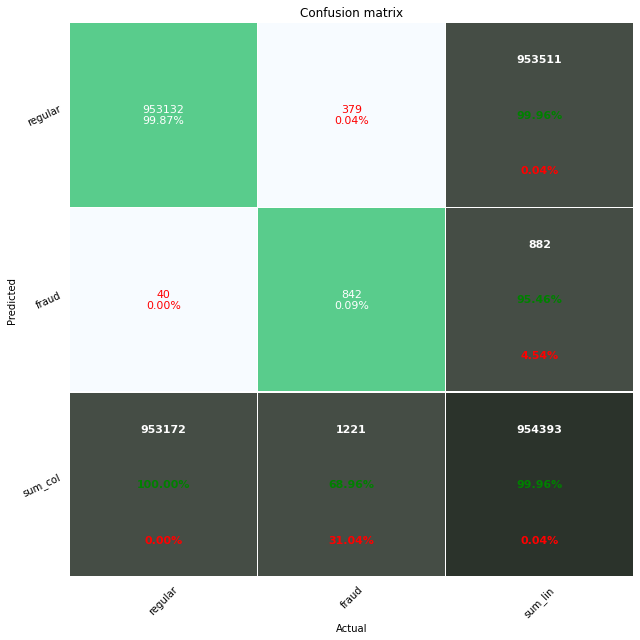

In [150]:
# Confusion Matrix

from pretty_confusion_matrix import pp_matrix_from_data

pp_matrix_from_data(test_labels, test_predictions, cmap='Blues', columns = ['regular','fraud'])
